In [90]:
# Import necessary libraries/modules
import vertica_python
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [91]:
# Set up the Vertica Connection Information
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')

conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False
            }

connection = vertica_python.connect(**conn_info)
cur = connection.cursor('dict')

# Instructor Paced Courses
- That have already passed their announcement window (courses have started already) and have also ended

In [92]:
query = """
SELECT
	a.course_id,
	DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
	pacing_type,
	level_type,
    course_partner,
    content_language,
    course_run_number,
	sum_enrolls,
    sum_bookings
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
WHERE
    course_start_date <= CURRENT_DATE()
AND
	course_end_date <= CURRENT_DATE()
AND
	DATEDIFF(day, course_announcement_date, course_start_date)>0
AND
	pacing_type = 'instructor_paced'
AND
	sum_enrolls > 100;
"""

cur.execute(query)

instructor_paced = pd.DataFrame(cur.fetchall())

[(0, 300)]

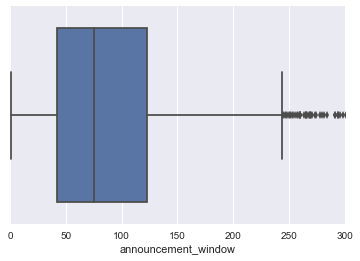

In [93]:
ax = sns.boxplot(x=instructor_paced['announcement_window'])
ax.set(xlim=(0, 300))

[(0, 300)]

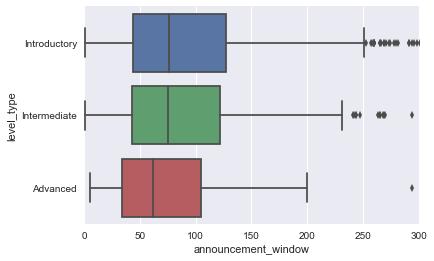

In [94]:
ax = sns.boxplot(x=instructor_paced['announcement_window'], y=instructor_paced['level_type'])
ax.set(xlim=(0, 300))

In [86]:
print instructor_paced['announcement_window'].quantile(.25)
print instructor_paced['announcement_window'].quantile(.50)
print instructor_paced['announcement_window'].quantile(.75)

42.0
75.0
123.0


# Is there a relationship between announcement window and enrollments?

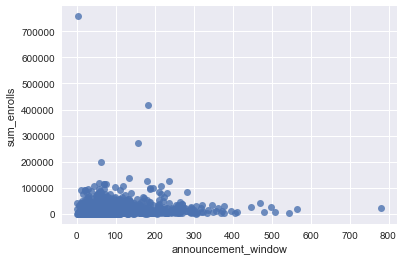

In [65]:
ax = sns.regplot(x=instructor_paced['announcement_window'], y=instructor_paced['sum_enrolls'], fit_reg=False)

In [66]:
# Splitting course announcement dates into Quartiles to see if there's a significant difference between announcement lead time and enrollments
instructor_paced['Announcement Window Quartile'] = 'Null'

instructor_paced['Announcement Window Quartile'][instructor_paced['announcement_window'] >= instructor_paced['announcement_window'].quantile(.75)] = 'Q4'
instructor_paced['Announcement Window Quartile'][instructor_paced['announcement_window'] < instructor_paced['announcement_window'].quantile(.75)] = 'Q3'
instructor_paced['Announcement Window Quartile'][instructor_paced['announcement_window'] < instructor_paced['announcement_window'].quantile(.50)] = 'Q2'
instructor_paced['Announcement Window Quartile'][instructor_paced['announcement_window'] < instructor_paced['announcement_window'].quantile(.25)] = 'Q1'

C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\_

In [67]:
# Group by Quartiles to see Mean/Median of Enrollments for each Announcement Window Quartile
print instructor_paced.groupby(['Announcement Window Quartile'])['sum_enrolls'].mean()
print instructor_paced.groupby(['Announcement Window Quartile'])['sum_enrolls'].median()

print instructor_paced.groupby(['Announcement Window Quartile'])['announcement_window'].mean()
print instructor_paced.groupby(['Announcement Window Quartile'])['announcement_window'].median()

Announcement Window Quartile
Q1    12547.922170
Q2    14213.833729
Q3    14333.223476
Q4    17936.347826
Name: sum_enrolls, dtype: float64
Announcement Window Quartile
Q1     5713
Q2     7307
Q3     8438
Q4    10040
Name: sum_enrolls, dtype: int64
Announcement Window Quartile
Q1     25.750000
Q2     57.821853
Q3     93.645598
Q4    191.292906
Name: announcement_window, dtype: float64
Announcement Window Quartile
Q1     27
Q2     57
Q3     91
Q4    169
Name: announcement_window, dtype: int64


# Looks like there could be a relationship where longer announcement window leads to higher enrollments
- which makes sense

[(0, 50000)]

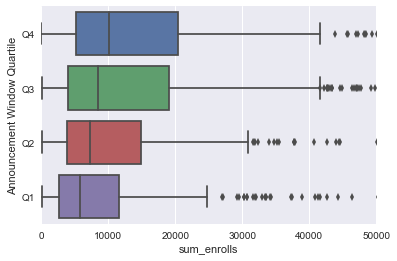

In [69]:
ax = sns.boxplot(x=instructor_paced['sum_enrolls'], y=instructor_paced['Announcement Window Quartile'], order=['Q4', 'Q3', 'Q2', 'Q1'])
ax.set(xlim=(0, 50000))

# But is there a significant difference?

In [70]:
from scipy.stats import ttest_ind

bottom_quartile = instructor_paced[instructor_paced['Announcement Window Quartile'] == 'Q1']['sum_enrolls']
top_quartile = instructor_paced[instructor_paced['Announcement Window Quartile'] == 'Q4']['sum_enrolls']

print (ttest_ind(bottom_quartile, top_quartile))

Ttest_indResult(statistic=-2.2716475264445299, pvalue=0.023354379995268369)


# Self Paced Courses

In [96]:
query = """
SELECT
	a.course_id,
	DATEDIFF(day, course_announcement_date, course_start_date) AS announcement_window,
	pacing_type,
	level_type,
    course_partner,
    content_language,
    course_run_number,
	sum_enrolls,
    sum_bookings
FROM
	business_intelligence.course_master a
LEFT JOIN
	business_intelligence.course_stats_summary b
ON
	a.course_id = b.course_id
WHERE
    course_start_date <= CURRENT_DATE()
AND
	course_end_date <= CURRENT_DATE()
AND
	DATEDIFF(day, course_announcement_date, course_start_date)>0
AND
	pacing_type = 'self_paced'
AND
    sum_enrolls > 100
"""

cur.execute(query)

self_paced = pd.DataFrame(cur.fetchall())

[(0, 150)]

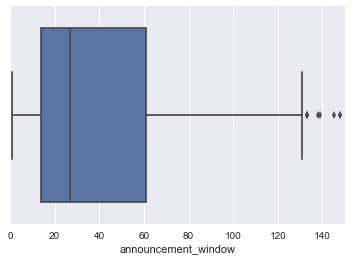

In [88]:
ax = sns.boxplot(x=self_paced['announcement_window'])
ax.set(xlim=(0, 150))

[(0, 150)]

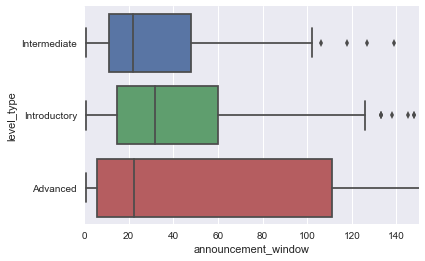

In [98]:
ax = sns.boxplot(x=self_paced['announcement_window'], y=self_paced['level_type'])
ax.set(xlim=(0, 150))

In [89]:
print self_paced['announcement_window'].quantile(.25)
print self_paced['announcement_window'].quantile(.5)
print self_paced['announcement_window'].quantile(.75)

13.75
27.0
61.0


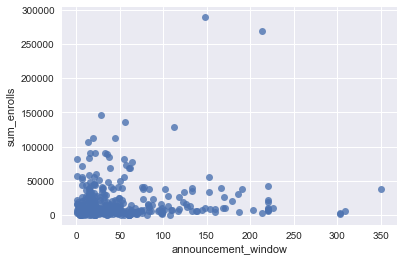

In [73]:
ax = sns.regplot(x=self_paced['announcement_window'], y=self_paced['sum_enrolls'], fit_reg=False)

In [74]:
# Splitting course announcement dates into Quartiles to see if there's a significant difference between announcement lead time and enrollments
self_paced['Announcement Window Quartile'] = 'Null'

self_paced['Announcement Window Quartile'][self_paced['announcement_window'] >= self_paced['announcement_window'].quantile(.75)] = 'Q4'
self_paced['Announcement Window Quartile'][self_paced['announcement_window'] < self_paced['announcement_window'].quantile(.75)] = 'Q3'
self_paced['Announcement Window Quartile'][self_paced['announcement_window'] < self_paced['announcement_window'].quantile(.50)] = 'Q2'
self_paced['Announcement Window Quartile'][self_paced['announcement_window'] < self_paced['announcement_window'].quantile(.25)] = 'Q1'

C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ochang\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\_

In [75]:
# Group by Quartiles to see Mean/Median of Enrollments for each Announcement Window Quartile
print self_paced.groupby(['Announcement Window Quartile'])['sum_enrolls'].mean()
print self_paced.groupby(['Announcement Window Quartile'])['sum_enrolls'].median()

print self_paced.groupby(['Announcement Window Quartile'])['announcement_window'].mean()
print self_paced.groupby(['Announcement Window Quartile'])['announcement_window'].median()

Announcement Window Quartile
Q1    12017.382353
Q2    18306.590476
Q3    20324.316832
Q4    20322.688679
Name: sum_enrolls, dtype: float64
Announcement Window Quartile
Q1     5752.5
Q2    10846.0
Q3     8574.0
Q4     7591.5
Name: sum_enrolls, dtype: float64
Announcement Window Quartile
Q1      6.764706
Q2     19.333333
Q3     41.623762
Q4    122.462264
Name: announcement_window, dtype: float64
Announcement Window Quartile
Q1     6.0
Q2    20.0
Q3    41.0
Q4    99.5
Name: announcement_window, dtype: float64


# Not as big of an effect for Self Paced
- Also note that Self Paced courses tend to have a smaller announcement window

[(0, 50000)]

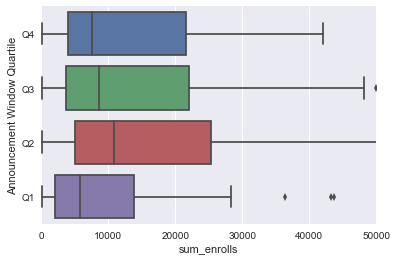

In [76]:
ax = sns.boxplot(x=self_paced['sum_enrolls'], y=self_paced['Announcement Window Quartile'], order=['Q4', 'Q3', 'Q2', 'Q1'])
ax.set(xlim=(0, 50000))

# However we still see significant results

In [77]:
bottom_quartile = self_paced[self_paced['Announcement Window Quartile'] == 'Q1']['sum_enrolls']
top_quartile = self_paced[self_paced['Announcement Window Quartile'] == 'Q4']['sum_enrolls']

print (ttest_ind(bottom_quartile, top_quartile))

Ttest_indResult(statistic=-1.8793701122793085, pvalue=0.061605875929027436)
